# CORD-19 text analysis

In this notebook, we perform a topic modelling analysis of CORD-19 publications.

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# load metadata (follow the other notebooks in the repository to create these)

df_meta = pd.read_csv("datasets_output/df_pub.csv",compression="gzip")
df_datasource = pd.read_csv("datasets_output/sql_tables/datasource.csv",sep="\t",header=None,names=['datasource_metadata_id', 'datasource', 'url'])
df_pub_datasource = pd.read_csv("datasets_output/sql_tables/pub_datasource.csv",sep="\t",header=None,names=['pub_id','datasource_metadata_id'])
df_cord_meta = pd.read_csv("datasets_output/sql_tables/cord19_metadata.csv",sep="\t",header=None,names=[ 'cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'])

In [139]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id,timestamp
0,0,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,NaN,1-4,10-5830-cvja-2020-016,32490506.0,NaN,pub.1128171889,NaN,2020-07-02 10:54:27.347501
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,NaN,2020-07-02 10:54:27.347501
2,2,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,10.1001/amajethics.2020.344,32345430.0,NaN,pub.1127182341,NaN,2020-07-02 10:54:27.347501
3,3,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,The AMA Journal of Ethic,22,5,e441-445,10.1001/amajethics.2020.441,32449663.0,NaN,pub.1127905371,NaN,2020-07-02 10:54:27.347501
4,4,What Should Health Science Journalists Do in E...,Journalists have long covered outbreaks of inf...,2020.0,1.0,AMA journal of ethics,NaN,NaN,NaN,10.1001/amajethics.2020.55,31958392.0,NaN,NaN,NaN,2020-07-02 10:54:27.347501


In [140]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'arxiv_id', 'timestamp'],
      dtype='object')

In [141]:
df_datasource

,datasource_metadata_id,datasource,url
0,0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...


#### Select just CORD-19

In [142]:
df_meta = df_meta.merge(df_pub_datasource, how="inner", left_on="pub_id", right_on="pub_id")
df_meta = df_meta.merge(df_datasource, how="inner", left_on="datasource_metadata_id", right_on="datasource_metadata_id")
df_cord19 = df_meta[df_meta.datasource_metadata_id==0]
df_cord19 = df_cord19.merge(df_cord_meta, how="inner", left_on="pub_id", right_on="pub_id")

In [143]:
df_meta.shape

(201599, 18)

In [144]:
df_cord19.shape

(140351, 25)

In [145]:
# publications without DOI will be missing from the network clustering analysis

df_cord19[pd.isnull(df_cord19["doi"])].shape

(13233, 25)

In [149]:
df_cord19[pd.isnull(df_cord19["abstract"])].shape

(31055, 25)

In [150]:
import re

def clean_year(s):
    if pd.isna(s):
        return np.nan
    if not (s>1900):
        return np.nan
    elif s>2020:
        return 2020
    return s

df_cord19["publication_year"] = df_cord19["publication_year"].apply(clean_year)

In [16]:
# we save a list of DOIs to filter data from Dimensions for the network clustering analysis (see notebook 3)

#pickle.dump(df_cord19[pd.notnull(df_cord19["doi"])]["doi"].to_list(),open("datasets_output/networks/cord-19-dois.pk","wb"))

## Text analysis

In [17]:
# TODO: add a language detection to remove all non-English

In [19]:
# concatenate abstracts and titles

# note that ~8k articles have no abstract
df_cord19["title"] = df_cord19["title"].fillna('')
df_cord19["abstract"] = df_cord19["abstract"].fillna('')
df_cord19["title_abstract"] = df_cord19.title +" "+df_cord19.abstract

In [20]:
#texts = df_cord19[(pd.notnull(df_cord19["title_abstract"])) & (df_cord19.publication_year>2019)].title_abstract.tolist()
texts = df_cord19[(pd.notnull(df_cord19["title_abstract"]))].title_abstract.tolist()
texts[0]

'Coronavirus disease 2019 (COVID-19) and simultaneous acute anteroseptal and inferior ST-segment elevation myocardial infarction. Coronavirus disease 2019 (COVID-19) is a recently recognised pandemic spreading rapidly from Wuhan, Hubei, to other provinces in China and to many countries around the world. The number of COVID-19-related deaths is steadily increasing. Acute ST-segment elevation myocardial infarction (STEMI) is a disease with high morbidity and mortality rates, and primary percutaneous coronary intervention is usually recommended for the treatment. A patient with diabetes mellitus and hypertension for five years was admitted to the emergency unit with symptoms of fever, cough and dyspnoea. These symptoms were consistent with viral pneumonia and a COVID PCR test was performed, which tested positive three days later. The patient had chest pain on the eighth day of hospitalisation. On electrocardiography, simultaneous acute inferior and anterior STEMI were identified. High lev

#### Topic modelling

In [21]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en

In [22]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [23]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]# token.is_alpha]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    #doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

CPU times: user 12min 30s, sys: 45.5 s, total: 13min 15s
Wall time: 14min


In [25]:
import pickle

pickle.dump(processed_docs, open("datasets_output/texts/processed_docs_cord19_scispacy.pk", "wb"))

In [16]:
import pickle

processed_docs = pickle.load(open("datasets_output/texts/processed_docs_cord19_scispacy.pk", "rb"))

In [26]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=50)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [27]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 10

In [28]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 65165
Number of docs: 140351 (140351)


In [29]:
dictionary.token2id["covid-19"]

28

In [30]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 12min 36s, sys: 3.3 s, total: 12min 40s
Wall time: 11min 50s


In [31]:
model.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.043*"respiratory" + 0.028*"infection" + 0.021*"virus" + 0.018*"patient" + 0.015*"child" + 0.013*"influenza" + 0.012*"acute" + 0.012*"clinical" + 0.012*"viral" + 0.011*"pneumonia"'),
 (1,
  '0.046*"covid-19" + 0.029*"COVID-19" + 0.023*"pandemic" + 0.017*"health" + 0.014*"sars-cov-2" + 0.012*"coronavirus" + 0.010*"2020" + 0.010*"public" + 0.010*"care" + 0.009*"2019"'),
 (2,
  '0.025*"group" + 0.023*"=" + 0.018*"p" + 0.013*"study" + 0.013*"<" + 0.011*"day" + 0.010*"compare" + 0.009*"p_=" + 0.009*"95" + 0.008*"rate"'),
 (3,
  '0.028*"virus" + 0.014*"sequence" + 0.012*"coronavirus" + 0.011*"strain" + 0.011*"gene" + 0.009*"assay" + 0.009*"sample" + 0.008*"antibody" + 0.008*"isolate" + 0.008*"detect"'),
 (4,
  '0.022*"study" + 0.011*"review" + 0.009*"include" + 0.009*"health" + 0.007*"result" + 0.007*"datum" + 0.007*"report" + 0.006*"intervention" + 0.006*"search" + 0.006*"evidence"'),
 (5,
  '0.026*"disease" + 0.023*"case" + 0.016*"infection" + 0.016*"outbreak" + 0.015*"SARS" + 0.0

In [154]:
# printout for LaTeX
#for t in model.show_topics(num_words=100, num_topics=params['num_topics'], formatted=False):
#    print("\\item \\textbf{Topic #%d}"%t[0]+": "+"``"+"'', ``".join([w[0] for w in t[1] if len(w[0])>3][:20])+"''.")

In [33]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [76]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
dims = df_local.dimensions_id.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [77]:
topics[0,:]

array([0.1292454 , 0.19328608, 0.        , 0.        , 0.        ,
       0.17505911, 0.3734979 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12392991])

In [78]:
model.get_document_topics(corpus[0])

[(0, 0.12924638),
 (1, 0.19328772),
 (5, 0.175054),
 (6, 0.3734987),
 (14, 0.123931594)]

In [79]:
df_topics = pd.DataFrame(topics)

In [80]:
df_topics["year"] = publication_years
df_topics["doi"] = dois
df_topics["dim_id"] = dims

In [81]:
from_which_year = 1980

grouped = df_topics.groupby('year')
#grouped = df_topics[df_topics.isin({'doi': clusters[3]})["doi"]].groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]
#df_grouped

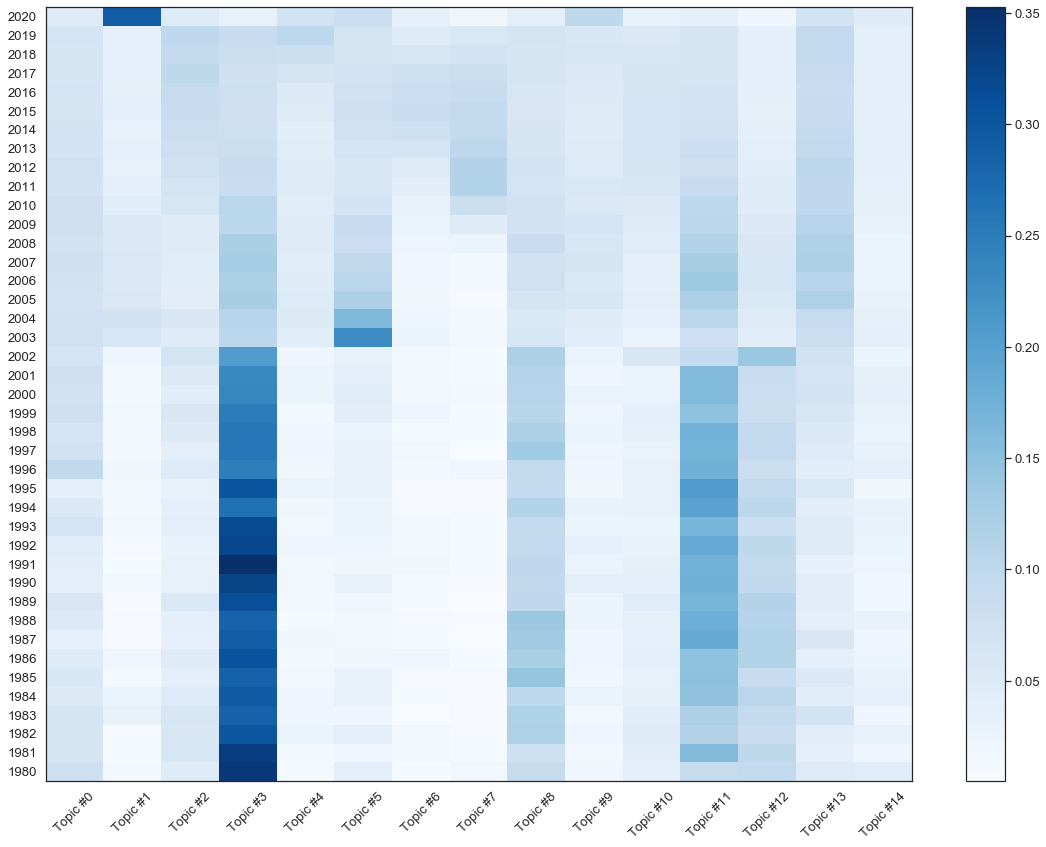

In [82]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_all_time_15.pdf")
plt.show()

#### Macrotopic analysis

In [83]:
# calculate topic distances
from scipy.spatial.distance import cosine, euclidean, jensenshannon

topics_distances = np.zeros((params['num_topics'],params['num_topics']))
topics_terms = model.state.get_lambda()

for k in range(params['num_topics']):
    for m in range(params['num_topics'])[k+1:]:
        d = jensenshannon(topics_terms[k,:],topics_terms[m,:])
        topics_distances[k][m] = d
        topics_distances[m][k] = d

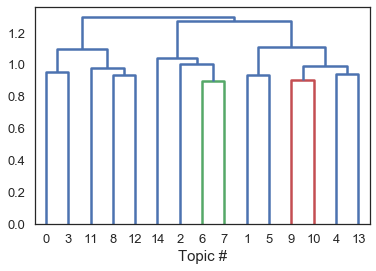

In [84]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model_hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_hc = model_hc.fit(topics_distances)
#plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plot the top three levels of the dendrogram
plot_dendrogram(model_hc, truncate_mode='level', p=10)
plt.xlabel("Topic #", fontsize=15)
plt.tick_params(labelsize=13)
plt.savefig("figures/tm_dendrogram.pdf")

In [85]:
# define macro topics

topic_labels = {
    "Clinical medicine": [2,6,7,14],
    "Coronavirus outbreaks": [1,5],
    "Epidemics": [9,10],
    "Immunology": [8,12],
    "Molecular biology": [3,11],
    "Public health": [0,4,13]
}

In [86]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
for d in range(len(docs)):
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        is_selected_topic[topic_to_label[x[0]]][d] += x[1]

In [87]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["dim_id"] = dims 

In [157]:
from_which_year = 1980

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti = grouped_ti.aggregate(np.sum)
df_grouped_ti = df_grouped_ti[df_grouped_ti.index >= from_which_year]

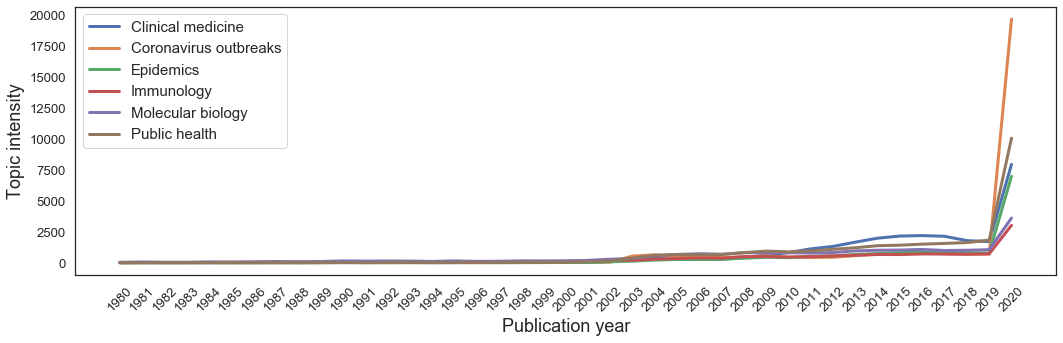

In [158]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti.shape[0]), [int(x) for x in df_grouped_ti.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Publication year",fontsize=18)
plt.tight_layout()  # fixes margins
#plt.savefig("figures/topic_model_trends_mean.pdf")

#### Network cluster to topic analysis - 1

Use the extended citation clustering and characterize with topics.

In [62]:
clustering_solution_df = pd.read_csv("datasets_input/paper_CORD19_supporting_materials/clustering_01072020.csv", sep=";",header=0)

In [63]:
clustering_solution_df.shape

(104508, 3)

In [64]:
clustering_solution_df.head()

,id,clusters_0,clusters_1
0,pub.1027207099,0,0
1,pub.1027223267,12,10
2,pub.1027236442,33,25
3,pub.1027256915,30,23
4,pub.1027274375,23,19


In [65]:
# clusters_0 contains smaller clusters

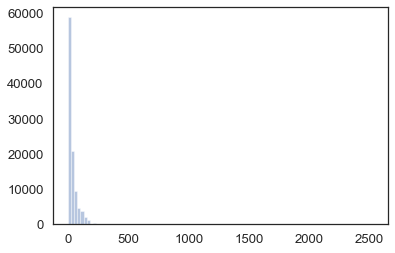

In [66]:
sns.distplot(clustering_solution_df.clusters_0.values, kde=False, norm_hist=False, bins=100)

In [67]:
# clusters_1 contains larger clusters

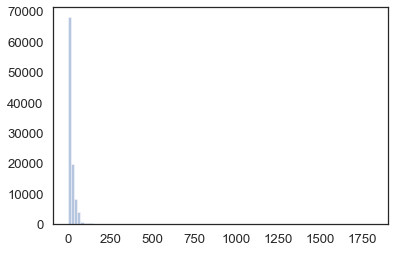

In [68]:
sns.distplot(clustering_solution_df.clusters_1.values, kde=False, norm_hist=False, bins=100)

In [155]:
which_clustering = 0

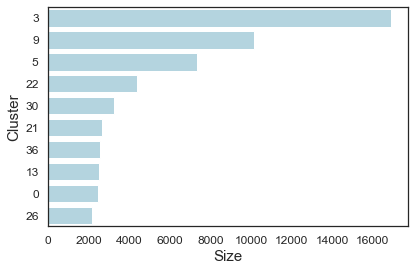

In [156]:
df_sub = clustering_solution_df[clustering_solution_df["clusters_%d"%which_clustering].isin(clustering_solution_df["clusters_%d"%which_clustering].value_counts()[:10].index.tolist())]
b = sns.countplot(y="clusters_%d"%which_clustering, data=df_sub, order=df_sub["clusters_%d"%which_clustering].value_counts().index, color='lightblue')
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Size",fontsize=15)
b.set_ylabel("Cluster",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/clustering_size_%d.pdf"%which_clustering)

In [126]:
# characterize a cluster by Macro topics

cluster_topic_join_df = clustering_solution_df.merge(df_topic_intensity, how="left", left_on="id", right_on="dim_id")

In [133]:
which_cluster = 18

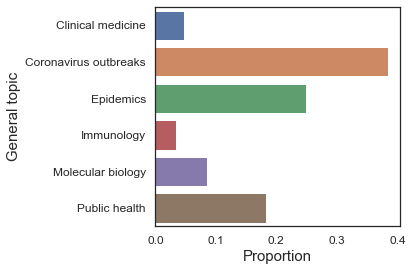

In [134]:
df_sub = cluster_topic_join_df[cluster_topic_join_df["clusters_%d"%which_clustering] == which_cluster][[mt for mt in topic_labels.keys()]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("General topic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/clustering_size_%d_cluster%d.pdf"%(which_clustering,which_cluster))

### Support sections

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Journal to topics

Using the Author topic model in gensim to map topics to journals.

In [34]:
# first, we select data for the top journals

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journals = df_local.journal.tolist()

In [35]:
how_many = 20

journal_names = df_local.journal.value_counts().index.to_list()
journal2doc = {j:[] for j in list(set(journal_names))}

In [36]:
for n,j in enumerate(journal_names):
    journal2doc[j].append(n)

In [37]:
from gensim.models import AuthorTopicModel

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
%time model_j = AuthorTopicModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary.id2token, \
                author2doc=journal2doc, chunksize=2000, passes=params['passes'], eval_every=5, \
                iterations=100, random_state=params['random_state'])

CPU times: user 57 s, sys: 550 ms, total: 57.6 s
Wall time: 40.8 s


In [38]:
model_j.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.013*"disease" + 0.007*"health" + 0.005*"model" + 0.005*"patient" + 0.005*"study" + 0.004*"datum" + 0.004*"risk" + 0.004*"SARS" + 0.004*"protein" + 0.004*"case"'),
 (1,
  '0.040*"cell" + 0.022*"virus" + 0.009*"mouse" + 0.009*"infection" + 0.008*"viral" + 0.006*"abstract" + 0.006*"culture" + 0.006*"response" + 0.005*"rat" + 0.005*"t"'),
 (2,
  '0.019*"virus" + 0.018*"cell" + 0.018*"rna" + 0.014*"protein" + 0.007*"abstract" + 0.007*"viral" + 0.006*"mrna" + 0.005*"sequence" + 0.005*"coronavirus" + 0.005*"mouse"'),
 (3,
  '0.010*"fipv" + 0.009*"feline" + 0.009*"study" + 0.008*"volume" + 0.006*"infectious" + 0.006*"human" + 0.005*"content" + 0.005*"index" + 0.005*"group" + 0.005*"chapter"'),
 (4,
  '0.011*"antibody" + 0.009*"bovine" + 0.009*"disease" + 0.007*"canine" + 0.007*"monoclonal" + 0.007*"dog" + 0.007*"infection" + 0.006*"use" + 0.005*"monoclonal_antibody" + 0.005*"bcv"'),
 (5,
  '0.009*"strain" + 0.007*"sequence" + 0.006*"p" + 0.006*"study" + 0.005*"China" + 0.005*"identif

In [39]:
model_j["PLoS ONE"]

[(1, 0.26377487722112225), (5, 0.7256559932323484)]

In [40]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journal_names_reduced = [j for j in reversed(df_local.journal.value_counts()[:how_many].index.to_list())]
topics = np.zeros((len(journal_names_reduced),model_j.num_topics))

for n,j in enumerate(journal_names_reduced):
    for t in model_j[j]:
        topics[n][t[0]] = t[1]

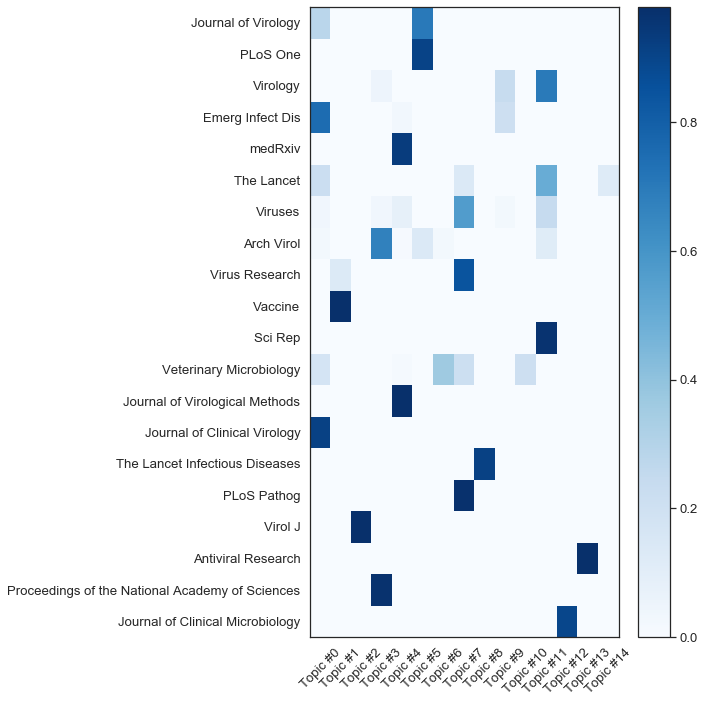

In [41]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics, norm=None, cmap='Blues')
plt.yticks(np.arange(how_many)+0.5, journal_names_reduced)
plt.xticks(np.arange(model_j.num_topics)+0.5, ["Topic #"+str(n) for n in range(model_j.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_top_journals.pdf")
plt.show()

In [42]:
# TODO: match topics here with topics above, or directly work with the topics above for all journals

#### Correlated topic model

With tomotopy.

In [20]:
import tomotopy as tp

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
mdl = tp.CTModel(k=params['num_topics'],min_cf=min_wordcount,min_df=2)
for doc in docs:
    mdl.add_doc(doc)

for i in range(0, 300, 25):
    mdl.train(25)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

Iteration: 0	Log-likelihood: -7.952682493160052
Iteration: 25	Log-likelihood: -7.580369381135443
Iteration: 50	Log-likelihood: -7.18383278109214
Iteration: 75	Log-likelihood: -6.8724311307285975
Iteration: 100	Log-likelihood: -6.692760464720625
Iteration: 125	Log-likelihood: -6.606490762439231
Iteration: 150	Log-likelihood: -6.559329422748022
Iteration: 175	Log-likelihood: -6.525913741406331
Iteration: 200	Log-likelihood: -6.511598970528629
Iteration: 225	Log-likelihood: -6.505459009571211
Iteration: 250	Log-likelihood: -6.502068255244552
Iteration: 275	Log-likelihood: -6.496780764407905


In [21]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=7))

Top 10 words of topic #0
[('virus', 0.15144172310829163), ('infection', 0.08410266786813736), ('viral', 0.06533856689929962), ('human', 0.049547962844371796), ('host', 0.02498638443648815), ('role', 0.022717703133821487), ('type', 0.019872356206178665)]
Top 10 words of topic #1
[('disease', 0.04943253844976425), ('model', 0.026093825697898865), ('system', 0.024129800498485565), ('factor', 0.019617542624473572), ('development', 0.01689882203936577), ('change', 0.01245930790901184), ('important', 0.011822817847132683)]
Top 10 words of topic #2
[('influenza', 0.04502635821700096), ('day', 0.021252159029245377), ('child', 0.02024831809103489), ('p', 0.015896260738372803), ('pandemic', 0.013804404996335506), ('pneumonia', 0.013598648831248283), ('age', 0.013355482369661331)]
Top 10 words of topic #3
[('strain', 0.024857645854353905), ('effect', 0.022751107811927795), ('increase', 0.02177148498594761), ('level', 0.021649908274412155), ('suggest', 0.02157275564968586), ('different', 0.0204645

In [25]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
topics_corr = np.zeros((len(docs),params['num_topics']))

for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        topics_corr[n][m] = t

In [26]:
df_topics_corr = pd.DataFrame(topics_corr)

In [27]:
df_topics_corr["year"] = publication_years
df_topics_corr["doi"] = dois

In [28]:
from_which_year = 1980

grouped_corr = df_topics_corr.groupby('year')
df_grouped_corr = grouped_corr.aggregate(np.mean)
df_grouped_corr = df_grouped_corr[df_grouped_corr.index >= from_which_year]
#df_grouped

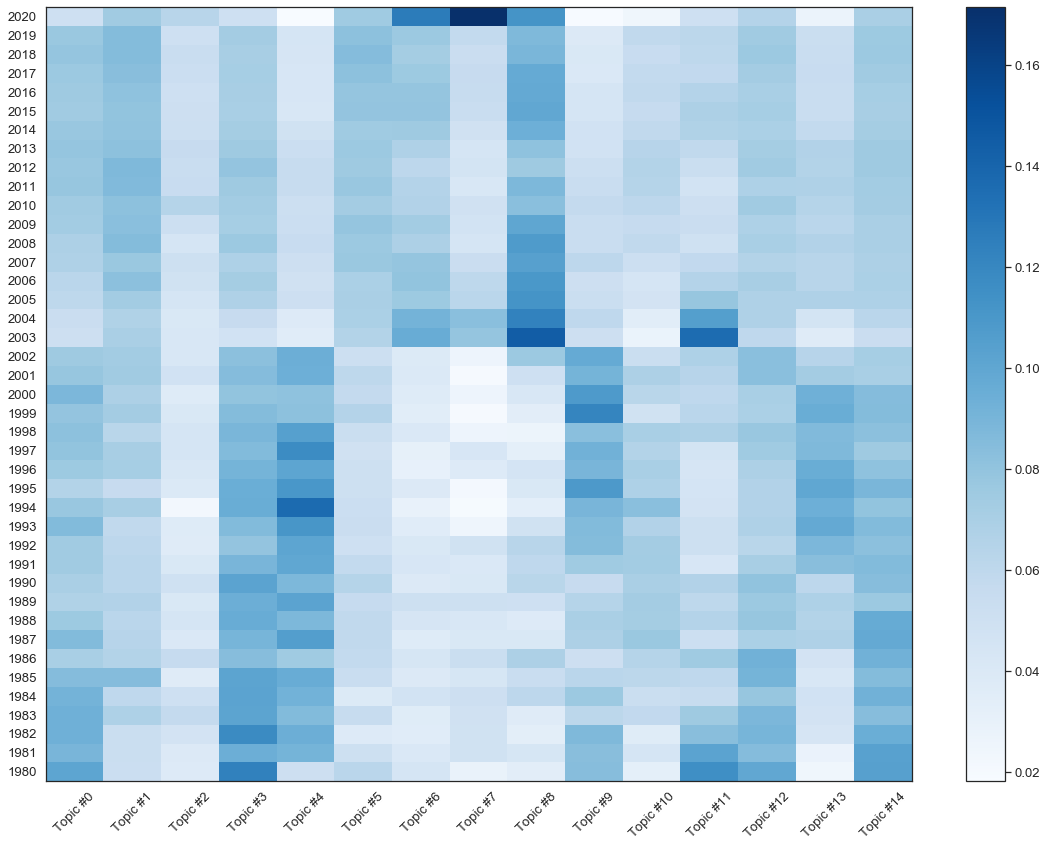

In [29]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped_corr.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped_corr.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped_corr.index.values])
plt.xticks(np.arange(df_grouped_corr.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_all_time_15.pdf")
plt.show()

In [30]:
# topic correlations

topics_correlations = np.zeros((mdl.k,mdl.k))

for k in range(mdl.k):
    for m,c in enumerate(mdl.get_correlations(k)):
        topics_correlations[k][m] = c

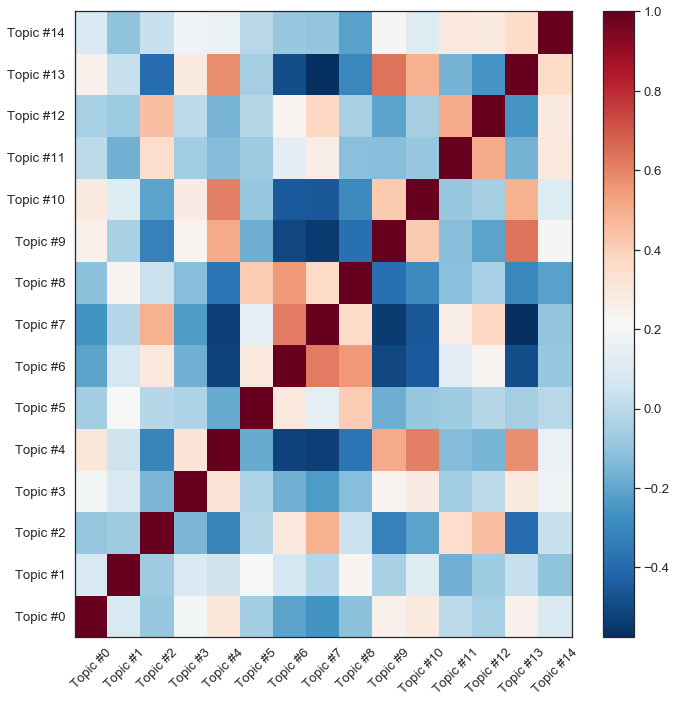

In [31]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_correlations_15.pdf")

#### Language modelling, semantic spaces and clustering

Future work.